In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from typing import Iterator
import torch
from torch.utils.data import Dataset

/root/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./mdshc_hk.csv')
label_columns = ['sCPS']
labels = df.loc[:, label_columns]

print(np.max(labels.to_numpy()))

6


Experiment (1), concatenate candidate mood states from section E1 and E3 for feature building

In [4]:
mood_columns = ['E1a', 'E1b', 'E1c', 'E1d', 'E1e','E1f', 'E1g', 'E1h', 'E1i', 'E3a', 'E3b', 'E3c', 'E3d', 'E3e']
exp1 = df.loc[:, mood_columns]

exp1.loc[:, 'E1a']


0        0
1        0
2        0
3        0
4        0
        ..
32711    0
32712    0
32713    0
32714    0
32715    0
Name: E1a, Length: 32716, dtype: int64

In [5]:
# fix data, experiment1.1, auto-fill zeros

exp11 = exp1.copy(deep=True)

for column in mood_columns:
    exp11.fillna({column: 0}, inplace=True)

In [6]:
# fix data, experiment1.2, auto-fill unknowns=3

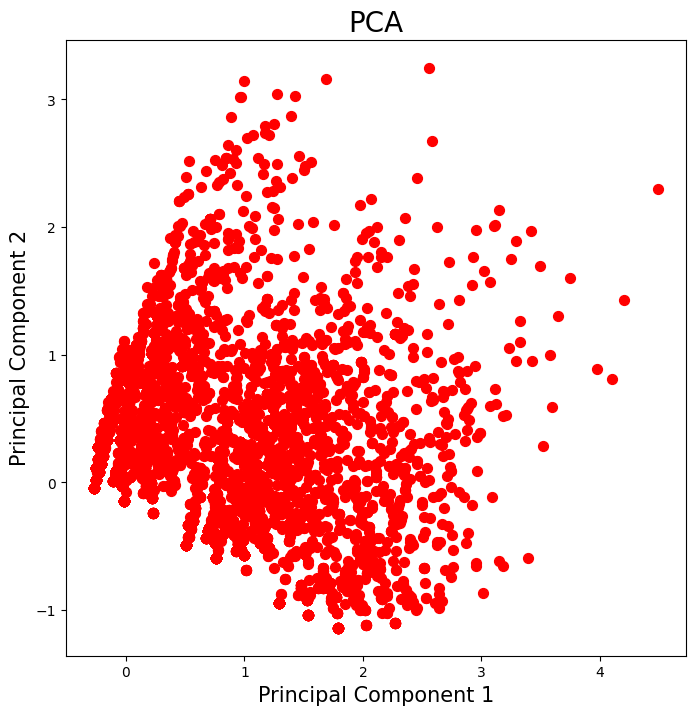

In [7]:
# without normalization, pca analysis,
# experiment 1.1, 2d after reduction
pca = PCA(n_components=2)
pca_2d_unnormalized = pca.fit_transform(exp11.values)

principalDf = pd.DataFrame(data = pca_2d_unnormalized
             , columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

ax.scatter(principalDf.loc[:, 'principal component 1']
               , principalDf.loc[:, 'principal component 2']
               , c = 'r'
               , s = 50)


In [8]:
# calculate covariance matrix and eigen-values
cov_matrix = np.cov(exp11.values.T, bias=True)
print(cov_matrix.shape)
eigenvalues, _ = np.linalg.eig(cov_matrix)
print(eigenvalues)

# Considering the four most principal components thereafter
pca = PCA(n_components=4)
pca_2d_unnormalized = pca.fit_transform(exp11.values)
print(type(pca_2d_unnormalized))

(14, 14)
[0.28596237 0.11894639 0.10139093 0.0111644  0.0800378  0.02246297
 0.02501309 0.06507529 0.05910083 0.03860565 0.05487777 0.04910737
 0.04544615 0.04572871]
<class 'numpy.ndarray'>


In [9]:
import random


class Exp1IterableDataset(Dataset):
    def __init__(self, feature, label, feature_columns, label_columns, seed=2023, is_infinite=True) -> None:
        self.features = feature.astype(np.float16) #feature_df.loc[:, feature_columns].to_numpy(dtype=np.float32)
        self.labels = label.astype(np.int32) #label.loc[:, label_columns].to_numpy(dtype=np.int32)
        self.dataset = np.concatenate([self.features, self.labels], axis=1)
        self.seed = seed

        self.is_infinite = is_infinite

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        length = self.__len__()
        random.seed(self.seed)
        while True:
            index = (random.randint(0, length) + index ) % length
            if self.dataset[index][-1] is None:
                print(index)
                continue
            return torch.tensor(self.dataset[index][:-1], dtype=torch.float32), torch.tensor(self.dataset[index][-1], dtype=torch.int64)
    

In [15]:
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self, input_feature_dim=4) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_feature_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 7)
        )
    
    def forward(self, features):
        return self.model(features)
    
    def loss(self, x, labels):
        return nn.CrossEntropyLoss(x, labels)

In [17]:
## def train code
epochs = 1000
batch_size = 100
learning_rate = 1e-3
input_feature_dim = 14
train_test_split_size = 0.8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNN(input_feature_dim=input_feature_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = Exp1IterableDataset(feature=exp11[:int(train_test_split_size * len(exp11))].to_numpy(dtype=np.float32), label=labels[:int(train_test_split_size * len(exp11))].to_numpy(dtype=np.int32), feature_columns=mood_columns, label_columns=label_columns)
val_dataset = Exp1IterableDataset(feature=exp11[int(train_test_split_size * len(exp11)):].to_numpy(dtype=np.float32), label=labels[int(train_test_split_size * len(exp11)):].to_numpy(dtype=np.int32), feature_columns=mood_columns, label_columns=label_columns)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset))

criterion = nn.CrossEntropyLoss()


for epoch in range(epochs):
    
    total_loss = 0.
    for feature, label in train_loader:
        feature = feature.to(device)
        label = label.to(device)
        
        model.train()
        optimizer.zero_grad()
        model.zero_grad()
        
        outputs = model(feature)
        loss = criterion(outputs, label)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()
        
    print(total_loss)
        
        


26172


/tmp/ipykernel_9060/966038146.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(self.dataset[index][:-1], dtype=torch.float32), torch.tensor(self.dataset[index][-1], dtype=torch.int64)


293.4057642817497
287.91424280405045
287.61168122291565
286.00738710165024
285.90108877420425
285.0601390004158
284.62300503253937
284.3201416730881
284.1418589949608
283.5786862373352
283.0718822479248
282.7132791876793
282.398142516613
281.86480724811554
281.6190502643585
281.28055518865585
280.8257851600647
280.23488360643387
279.7852286696434
279.72423923015594
279.3455926179886
278.6098772287369
278.62388718128204
278.215926527977
277.665140748024
277.4064328074455
277.17222929000854
276.64511799812317
276.4529049396515
276.25301337242126
275.813515663147
275.3580560684204
275.2652337551117
275.14663994312286
274.9878872036934
274.7959096431732
274.233734190464
274.15261912345886
274.17267137765884
273.8070523738861
273.9684103131294
273.467166185379
273.628818154335
273.2316589355469
273.3747079372406
273.0013625025749
273.15008103847504
272.8144632577896
272.8606357574463
272.8181251883507
272.6054593324661
272.6815856099129
272.54084569215775
272.4638252258301
272.5692402720451

KeyboardInterrupt: 